In [6]:
import numpy as np
from IPython.display import clear_output
import torch
import random
import matplotlib.pyplot as plt
import itertools
from collections import deque
from grid_env import Qmaze
from agent import Agent
%matplotlib inline

In [7]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [8]:
GAMMA = 0.9
BATCH_SIZE = 32
BUFFER_SIZE = 100000
MIN_REPLAY_SIZE = 1000
EPSILON_START = 1
EPSILON_END = 0.001
EPSILON_DECAY = 20000
TARGET_UPDATE_FREQ = 200


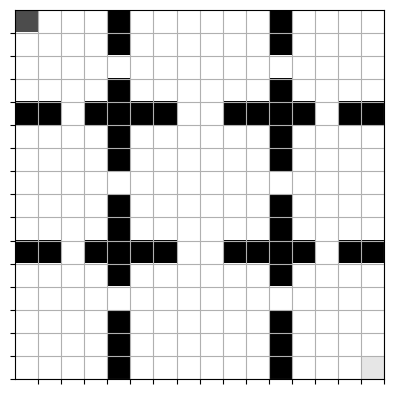

In [9]:
maze = [
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1., 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1., 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1., 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  1., 1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1., 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1., 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1., 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1., 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  1., 1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1., 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1., 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1., 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1., 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
]
env = Qmaze(maze)
Qmaze.show(env)

In [10]:
decays = [1000, 2000, 5000, 7000, 10000]
for epsilon_decay in decays:
    avg_returns = []
    episodes = []
    current_coverage = []
    coverage_steps = [200, 500, 1000, 50000]
    prefix = f"{epsilon_decay}_"

    # Noise defined
    for k in range(5):
        current_return = []

        replay_buffer = deque(maxlen=BUFFER_SIZE)
        rew_buffer = []
        temp_episodes = []

        rat_cell = (0, 0)
        env = Qmaze(maze)
        env.reset(rat_cell)
        obs = env.observe()

        agent = Agent(env, EPSILON_START, EPSILON_END, EPSILON_DECAY, GAMMA)
        cnt = 0
        coverage_counter = 0
        episode = 0
        for step in itertools.count():
            agent.counter += 1
            action = agent.choose_action(step, obs)

            new_obs, rew, done = env.act(action)
            Transition = (obs, action, rew, done, new_obs)
            replay_buffer.append(Transition)
            obs = new_obs


            if done != 'not_over':
                rat_cell = (0,0)
                env.reset(rat_cell)
                obs = env.observe()
                rew_buffer.append(GAMMA**(cnt))
                episode += 1
                cnt = 0

            if len(replay_buffer) > BATCH_SIZE:
                transitions = random.sample(replay_buffer, BATCH_SIZE)
                obses = np.asarray([t[0] for t in transitions])
                actions = np.asarray([t[1] for t in transitions])
                rews = np.asarray([t[2] for t in transitions])
                dones = np.asarray([t[3] for t in transitions])
                new_obses = np.asarray([t[4] for t in transitions])

                converted_dones = [done != 'not_over' for done in dones]

                obses_t = torch.as_tensor(obses, dtype=torch.float32).to(device)
                actions_t = torch.as_tensor(actions, dtype=torch.int64).unsqueeze(-1).to(device)
                rews_t = torch.as_tensor(rews, dtype=torch.float32).unsqueeze(-1).to(device)
                dones_t = torch.as_tensor(converted_dones, dtype=torch.float32).unsqueeze(-1).to(device)
                new_obses_t = torch.as_tensor(new_obses, dtype=torch.float32).to(device)

                agent.calculate_target(new_obses_t, rews_t, dones_t)
                agent.calculate_action_qvalues(obses_t, actions_t)
                agent.optimize_network()

            if step % TARGET_UPDATE_FREQ == 0:
                agent.update_target_network()

            if step in coverage_steps:
                if k == 0:
                    current_coverage.append(np.copy(env.coverage.reshape(1, env.coverage.shape[0], env.coverage.shape[1])))
                else:
                    current_coverage[coverage_counter] = np.concatenate(
                        [current_coverage[coverage_counter], env.coverage.reshape(1, env.coverage.shape[0], env.coverage.shape[1])], axis=0)

                coverage_counter += 1

            if step > 100000:
                episodes.append(np.copy(temp_episodes))
                avg_returns.append(np.copy(rew_buffer))
                break
            cnt += 1

            if step % 5000 == 0:
                temp_episodes.append(episode)
                
                print(f"trained {k} times - ep num = {episode}")
                
    min_length = np.min([len(array) for array in avg_returns])
    np.save(prefix+"episodes.npy", np.mean(episodes, axis=0))
    np.save(prefix+"score.npy", np.mean([array[:min_length] for array in avg_returns], axis=0))
    for s in range(len(coverage_steps)):
        np.save(prefix+f"heat_{coverage_steps[s]}.npy", np.mean(current_coverage[s], axis=0))

trained 0 times - ep num = 0
trained 0 times - ep num = 4


KeyboardInterrupt: 

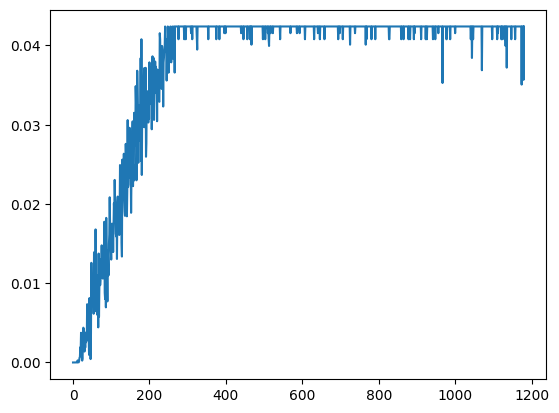

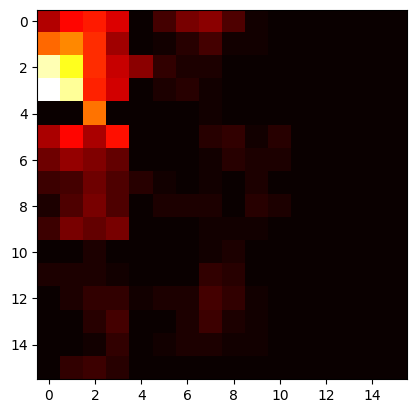

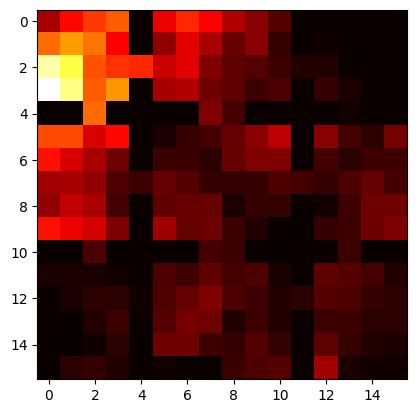

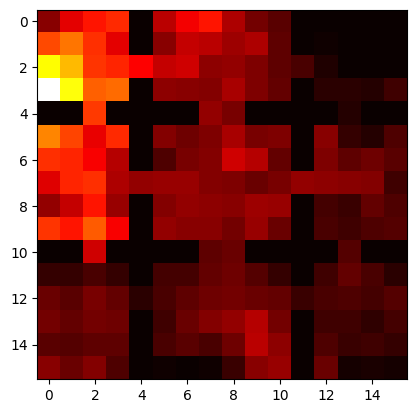

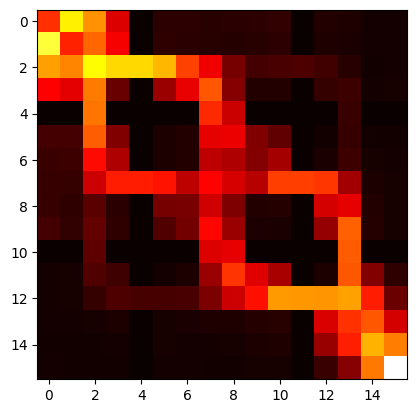

In [ ]:
plt.plot(np.mean([array[:min_length] for array in avg_returns], axis=0))
plt.show()
plt.imshow(np.mean(current_coverage[0], axis=0), cmap='hot', interpolation='nearest')
plt.show()
plt.imshow(np.mean(current_coverage[1], axis=0), cmap='hot', interpolation='nearest')
plt.show()
plt.imshow(np.mean(current_coverage[2], axis=0), cmap='hot', interpolation='nearest')
plt.show()
plt.imshow(np.mean(current_coverage[3], axis=0), cmap='hot', interpolation='nearest')
plt.show()

/tmp/ipykernel_892634/4224492261.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


564230


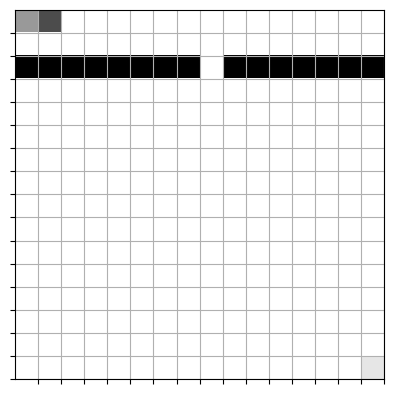

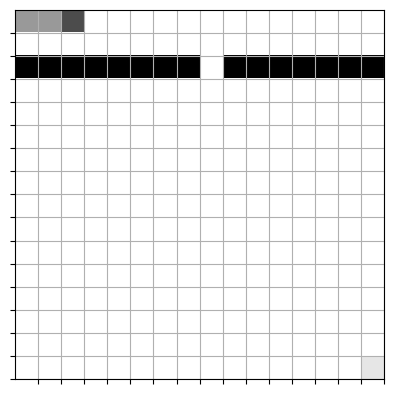

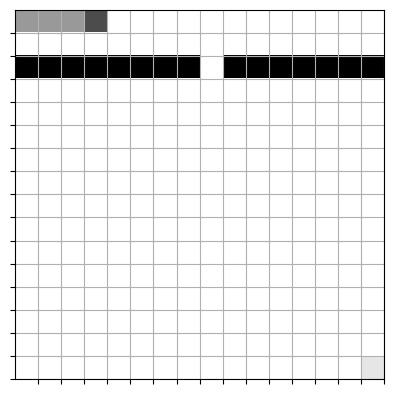

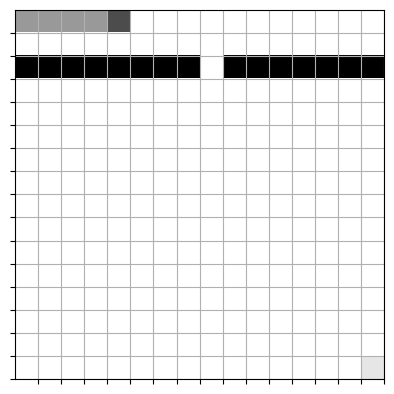

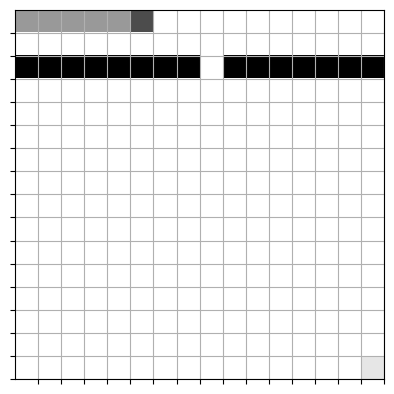

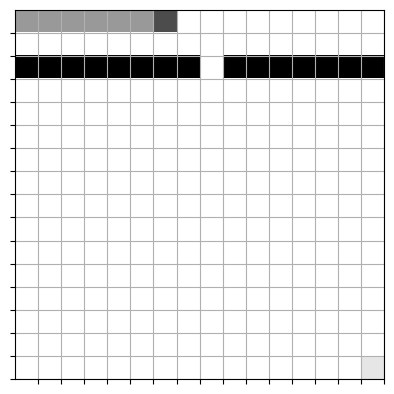

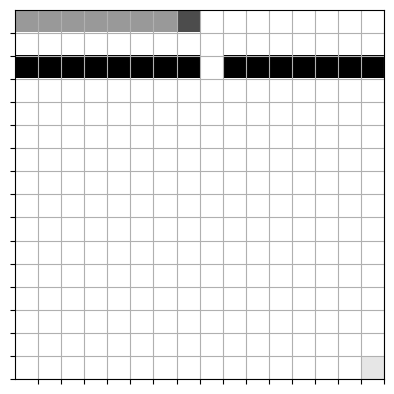

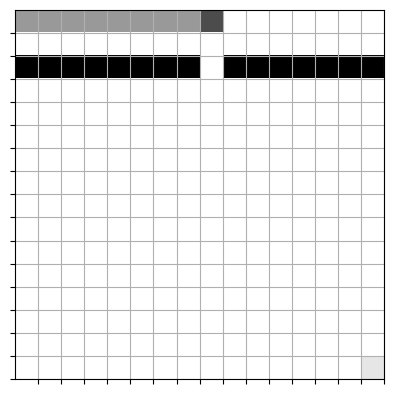

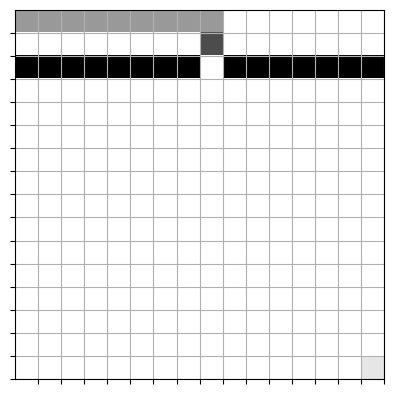

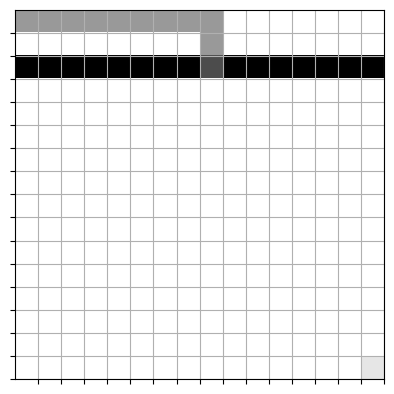

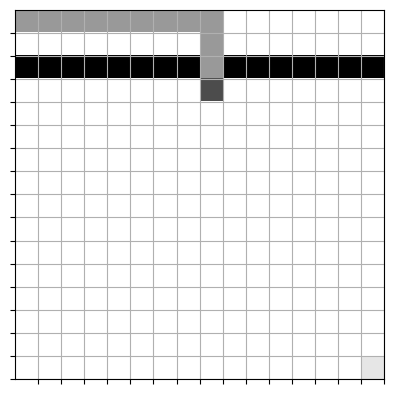

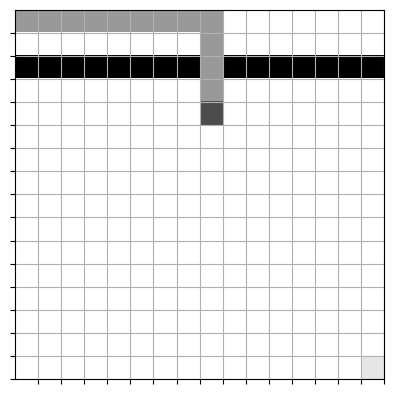

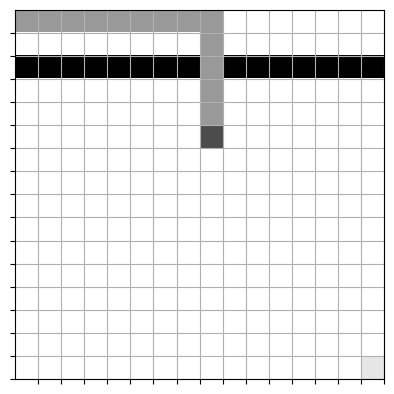

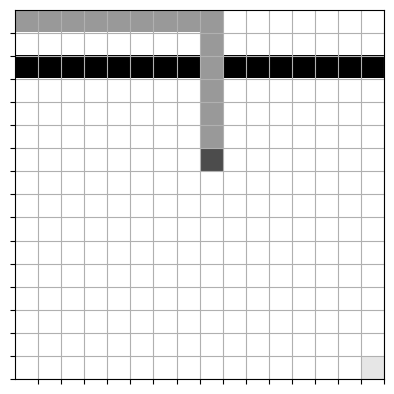

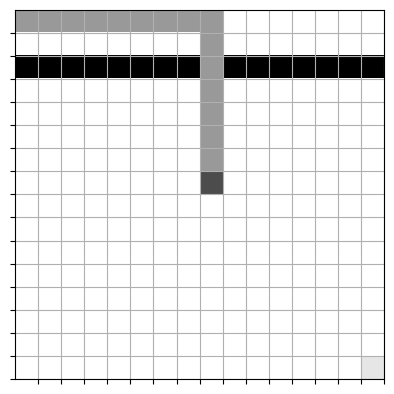

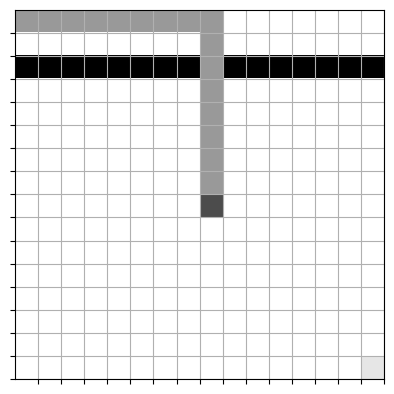

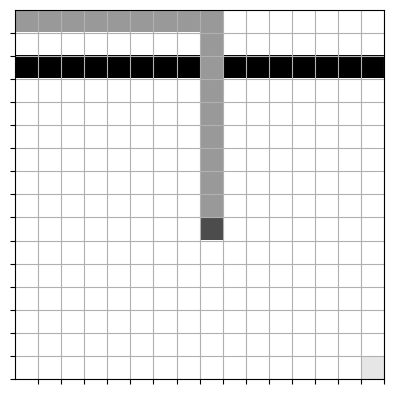

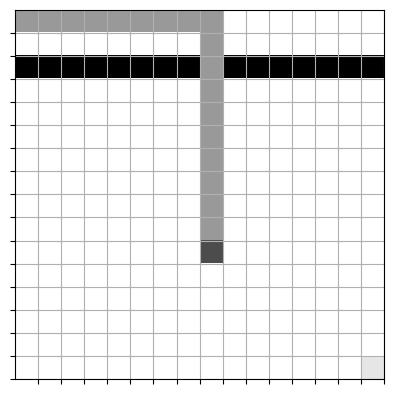

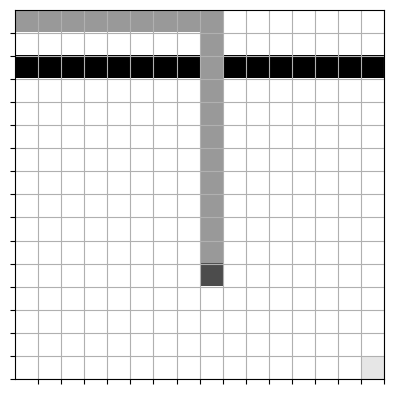

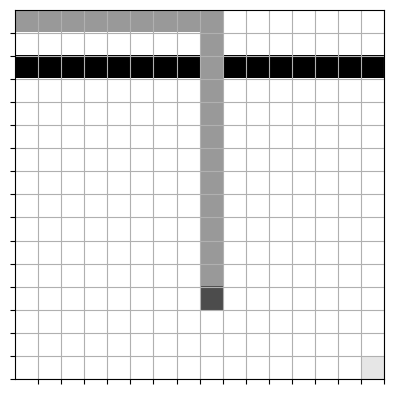

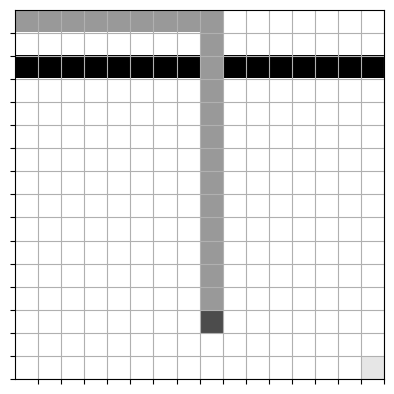

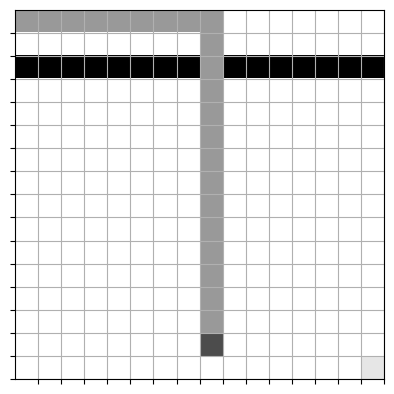

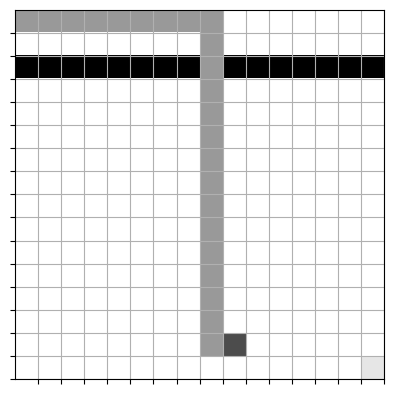

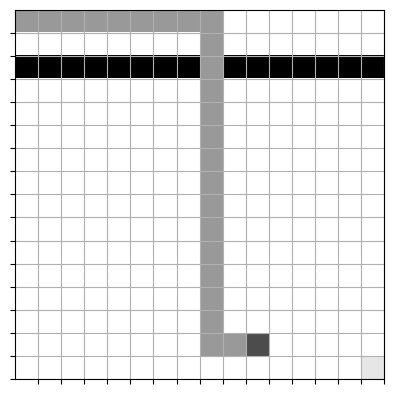

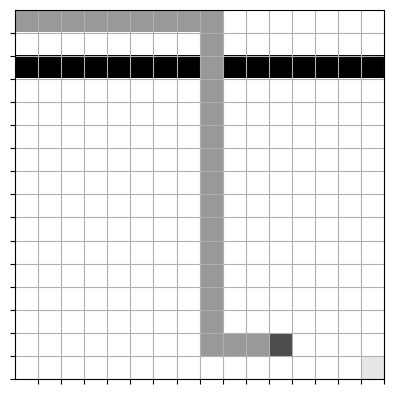

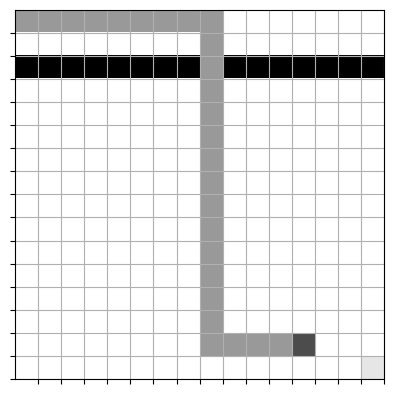

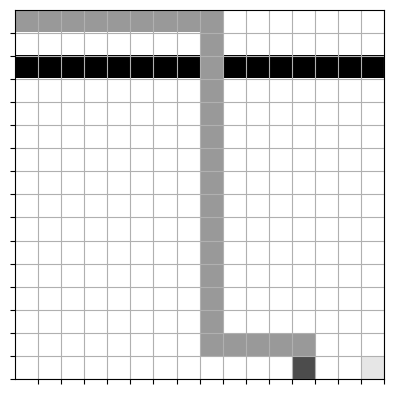

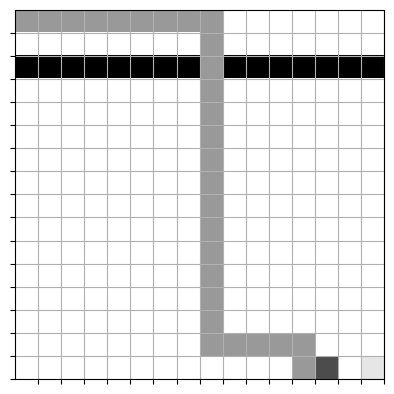

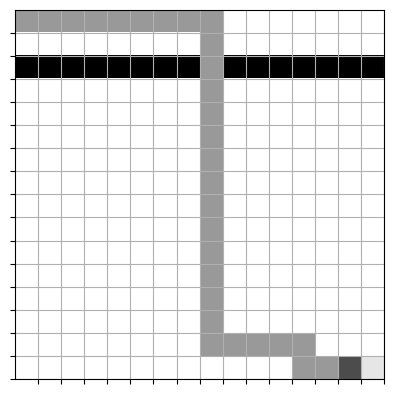

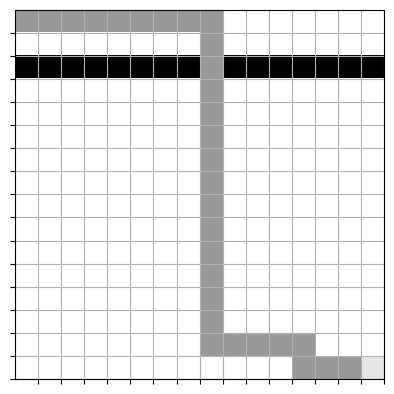

In [ ]:
env.reset((0, 0))
done = 'not_over'
while done == 'not_over':
    action = agent.choose_action(step, obs)

    new_obs, rew, done = env.act(action)

    step += 1
    obs = new_obs
    plt.figure()
    show(env)
print(step)